In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import KFold

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# use GPU!
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [3]:
# read data
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X, y = torch.FloatTensor(train.drop(['label'],axis=1).values), torch.tensor(train['label'].values)

training_size = 40000
X_train, y_train = X[:training_size], y[:training_size]
X_val, y_val = X[training_size:], y[training_size:]
X_test = torch.tensor(test.values)

X_train, y_train, X_val, y_val, X_test = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device), X_test.to(device).float()
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([40000, 784])
torch.Size([2000, 784])
torch.Size([28000, 784])


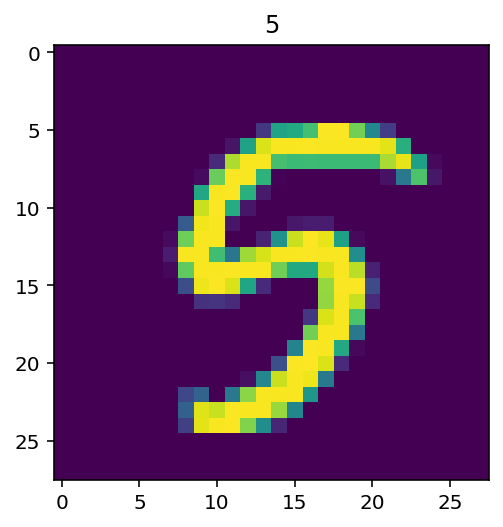

In [4]:
# visualize one sample
plt.imshow(X_train[8].reshape(28,28).cpu())
plt.title(y_train[8].item())
plt.show()

In [5]:
# make dataset and dataloader
dataset_train = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_val, y_val)

batch_size = 50
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [6]:
# build a CNN!
class mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [7]:
# loss function 
loss_function = F.cross_entropy

# instantiate model
model = mnist_CNN().to(device)

# optimizer for updating weights
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [8]:
# let's train
def training():
    n_epochs = 30
    train_loss = []
    val_loss = []
    iteration = []
    for epoch in tqdm(range(n_epochs)):
        iteration.append(epoch)

        model.train()
        for xb, yb in dataloader_train:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            loss = loss_function(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_loss.append(loss_function(model(X_train), y_train))
            val_loss.append(loss_function(model(X_val), y_val))
        
    return model, train_loss, val_loss, iteration

In [9]:
trained_model_cnn, lt, lv, it = training()

100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


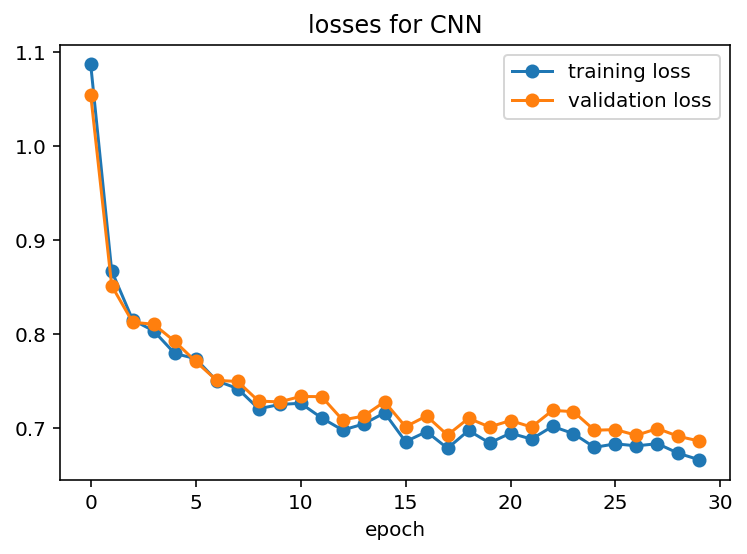

In [10]:
plt.plot(it, lt, 'o-', label='training loss')
plt.plot(it, lv, 'o-', label='validation loss')
plt.legend()
plt.title('losses for CNN')
plt.xlabel('epoch')
plt.show()

In [11]:
# output accuracy
y_train_pred = trained_model_cnn(X_train)
y_val_pred = trained_model_cnn(X_val)
y_test_pred = trained_model_cnn(X_test)

print('train accuracy (CNN): ' + str((y_train_pred.argmax(dim=1) == y_train).float().mean().item()))
print('val accuracy (CNN): ' + str((y_val_pred.argmax(dim=1) == y_val).float().mean().item()))

train accuracy (CNN): 0.7944249510765076
val accuracy (CNN): 0.7905000448226929


In [12]:
# save prediction
prediction = y_test_pred.argmax(dim=1)

# output to csv
t_np = prediction.cpu().detach().numpy()
df = pd.DataFrame(t_np)
df.to_csv("/kaggle/working/submission.csv",index=False)

# reload
df = pd.read_csv("/kaggle/working/submission.csv")
df

,0
0,2
1,0
2,6
3,9
4,3
...,...
27995,9
27996,7
27997,3
27998,9


In [13]:

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session